<a href="https://colab.research.google.com/github/febri009/Time-series-submission/blob/main/Time_Series_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> Nama: Febriyanti Paramudita

> Email: muditafebriyanti@gmail.com

> Domisili: Purwokerto, Jawa Tengah







# **Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM

In [ ]:
data_train = pd.read_csv('drive/MyDrive/powerconsumption.csv')
print(f'Jumlah datasets: {len(data_train)}')

Jumlah datasets: 52416


# **Mengubah dataset menjadi dataframe**

In [ ]:
data_train.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


# **Cek nilai yang hilang dari dataset**

In [ ]:
data_train.isnull().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [ ]:
#Hapus attribute yang tidak dipakai
data_train = data_train.drop(data_train.columns[[1, 2, 4, 5, 6, 7, 8]], axis=1)
display(data_train.head())

,Datetime,WindSpeed
0,1/1/2017 0:00,0.083
1,1/1/2017 0:10,0.083
2,1/1/2017 0:20,0.080
3,1/1/2017 0:30,0.083
4,1/1/2017 0:40,0.081


In [ ]:
#Cek nilai null
data_train.isnull().sum()
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Datetime   52416 non-null  object 
 1   WindSpeed  52416 non-null  float64
dtypes: float64(1), object(1)
memory usage: 819.1+ KB


# **Plot time series**

Text(0.5, 1.0, 'Wind Speed')

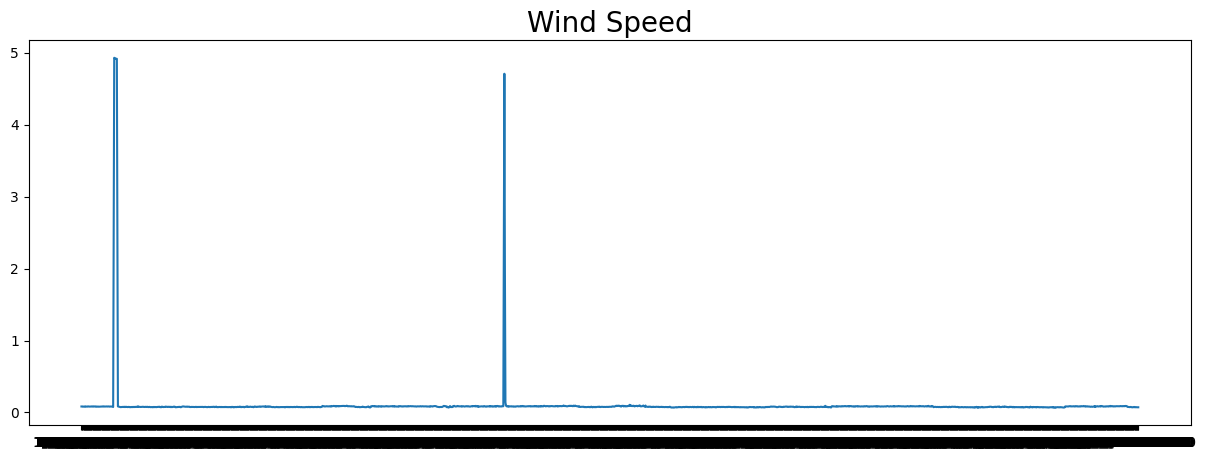

In [ ]:
date = data_train['Datetime'].values
wind = data_train['WindSpeed'].values

plt.figure(figsize=(15, 5))
plt.plot(date[:2000], wind[:2000])
plt.title('Wind Speed',
          fontsize=20)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(wind, date, test_size = 0.2, shuffle = False)
print("X Train= ",len(X_train))
print("X Validation = ",len(X_validation))
print("Y Train= ",len(y_train))
print("Y Validation= ",len(y_validation))

X Train=  41932
X Validation =  10484
Y Train=  41932
Y Validation=  10484


# **Mengembalikan label dan atribut dari dataset dalam bentuk batch**

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

# **Menggunakan 2 buah layer LSTM**

In [ ]:
tf.keras.backend.set_floatx('float64')
train_set = windowed_dataset(X_train, window_size=64, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(X_validation, window_size=64, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

# **Menghitung nilai MAE**

In [ ]:
mae = (data_train['WindSpeed'].max() - data_train['WindSpeed'].min()) * 0.1
print("Wind Speed Max= ",data_train['WindSpeed'].max())
print("Wind Speed Min= ",data_train['WindSpeed'].min())
print("MAE= ",mae)

Wind Speed Max=  6.483
Wind Speed Min=  0.05
MAE=  0.6433


# **Callback**

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.6433 and logs.get('val_mae')<0.6433):
      print("MAE < 10%")
      self.model.stop_training = True
callbacks = myCallback()


## **Optimizer, model compile, dan training**

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100,validation_data=validation_set,verbose=1, callbacks=[callbacks])

Epoch 1/100
419/419 [==============================] - 28s 54ms/step - loss: 1.7947 - mae: 2.0360 - val_loss: 1.0190 - val_mae: 1.2921
Epoch 2/100
419/419 [==============================] - 21s 51ms/step - loss: 1.7062 - mae: 2.0366 - val_loss: 1.0174 - val_mae: 1.4019
Epoch 3/100
419/419 [==============================] - 19s 45ms/step - loss: 1.6643 - mae: 2.0657 - val_loss: 1.0392 - val_mae: 1.4820
Epoch 4/100
419/419 [==============================] - 16s 39ms/step - loss: 1.6445 - mae: 2.0837 - val_loss: 1.0653 - val_mae: 1.5369
Epoch 5/100
419/419 [==============================] - 17s 40ms/step - loss: 1.6336 - mae: 2.0927 - val_loss: 1.0867 - val_mae: 1.5718
Epoch 6/100
419/419 [==============================] - 19s 45ms/step - loss: 1.6244 - mae: 2.0935 - val_loss: 1.1004 - val_mae: 1.5917
Epoch 7/100
419/419 [==============================] - 16s 39ms/step - loss: 1.6135 - mae: 2.0879 - val_loss: 1.1089 - val_mae: 1.6035
Epoch 8/100
419/419 [==============================] - 

# **Plot MAE**

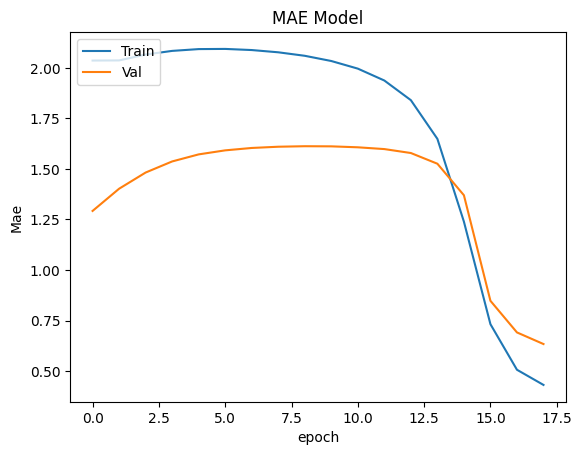

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# **Plot Loss**

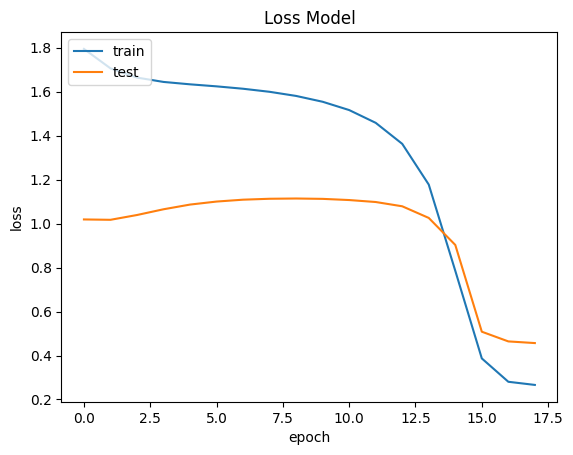

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()